<a href="https://colab.research.google.com/github/larissaaprats/Clas_RF_Dataframe/blob/main/Clas_RF_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dados**

---



# Gerar rótulos para o Dataset

Para rotular as imagens acesse o website https://www.makesense.ai e envie os dados para realizar a anotação.

Carregue o arquivo exportado no Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Criando CSV das imagens do DataSet

 - Cria o CSV com as colunas "image", "Hieght", 						"Width", "Channels", "Avg Blue", "Avg Red","Avg Green"

 
 obs:pode demorar um pouco

In [ ]:
# Required Libraries
from os import listdir #módulo python
from os.path import isfile, join #módulo python
from pathlib import Path #módulo python
import csv #módulo python
import numpy
import cv2 #OpenCV
import pandas as pd 

In [ ]:
my_file = Path("/content/drive/MyDrive/a-PROJETO INICIA_CIENT")

with open('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/images.csv', 'w', newline = '') as file:
		writer = csv.writer(file)
		
		writer.writerow(["image", "Hieght",
						"Width", "Channels",
						"Avg Blue", "Avg Red",
						"Avg Green"])

# Encontrar as cores e incorporar no CSV
mypath = ('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/imagens')

onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype = object)

for n in range(0, len(onlyfiles)):
	
	path = join(mypath,onlyfiles[n])
	images[n] = cv2.imread(join(mypath,onlyfiles[n]),
						cv2.IMREAD_UNCHANGED)
	
	img = cv2.imread(path)
	h,w,c = img.shape
#	print(h, w, c)
	
	avg_color_per_row = numpy.average(img, axis = 0)
	avg_color = numpy.average(avg_color_per_row, axis = 0)
	
	with open('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/images.csv', 'a', newline = '') as file:
		writer = csv.writer(file)
		writer.writerow([n+1, onlyfiles[n], h, w, c,
						avg_color[0], avg_color[1],
						avg_color[2]])
		file.close()


 - Transforma esse csv em Dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/images.csv')
data_img = pd.DataFrame (df)
data_img.head()

,image,Hieght,Width,Channels,Avg Blue,Avg Red,Avg Green
1,DJI_0067 (1).JPG,3000,4000,3,84.556356,139.428232,126.152125
2,DJI_0068 (1).JPG,3000,4000,3,82.688553,139.683396,128.866103
3,DJI_0069 (1).JPG,3000,4000,3,82.120196,138.881738,129.961076
4,DJI_0070 (1).JPG,3000,4000,3,81.216746,138.818663,129.502779
5,DJI_0071 (1).JPG,3000,4000,3,80.701832,139.392944,130.150816


- Cria Dataframe dos rótulos

In [ ]:
df = pd.read_json('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/labels_my-project-name_2021-06-28-11-27-05.json')
data_labels = pd.DataFrame (df)
data_labels.head()


,image,annotations
0,DJI_0067.JPG,[vegetação densa]
1,DJI_0068.JPG,[vegetação densa]
2,DJI_0069.JPG,[vegetação densa]
3,DJI_0070.JPG,[vegetação densa]
4,DJI_0071.JPG,[vegetação densa]


- Faz a união dos Dataframes criados

In [ ]:
data= data_img.join(data_labels.set_index('image'), on='image')
data.to_csv(r'/content/drive/MyDrive/a-PROJETO INICIA_CIENT/Dataframe.csv', index = False, header=True)
dd = pd.read_csv('/content/drive/MyDrive/a-PROJETO INICIA_CIENT\Dataframe.csv')
dd.head()

,image,Hieght,Width,Channels,Avg Blue,Avg Red,Avg Green,annotations
0,DJI_0067 (1).JPG,3000,4000,3,84.556356,139.428232,126.152125,NaN
1,DJI_0068 (1).JPG,3000,4000,3,82.688553,139.683396,128.866103,NaN
2,DJI_0069 (1).JPG,3000,4000,3,82.120196,138.881738,129.961076,NaN
3,DJI_0070 (1).JPG,3000,4000,3,81.216746,138.818663,129.502779,NaN
4,DJI_0071 (1).JPG,3000,4000,3,80.701832,139.392944,130.150816,NaN




*   Reirar nome, altura, largura e canais




# **Classificação Random Forest**

---



# Hiperparâmetros

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

#carrega o dataset
train = pd.read_csv('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/Dataframe_noatribute.csv')
train.head()


#divide em treino (70%) e teste (30%), onde x=dados sem rotulos e y=rotulos
x_train, x_test, y_train, y_test = train_test_split(train.drop('annotations',
                                                    axis=1),
                                                    train['annotations'],
                                                    test_size=0.3)

print('O dataset de treino possui {} imagens e o de teste {} imagens.'.format(x_train.shape[0], x_test.shape[0]))
print('------------------------------------------')


#codifica os valores categóricos dos dados e os converte em números
enc = OrdinalEncoder()
x_train[["image"]] = enc.fit_transform(x_train[["image"]])
x_test[["image"]] = enc.fit_transform(x_test[["image"]])

rf = RandomForestClassifier ()


n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf,

param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(x_train,y_train)

# this prints the contents of the parameters in the random grid
print ('Random grid: ', random_grid, '\n')

# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

O dataset de treino possui 174 imagens e o de teste 75 imagens.
------------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.4s


Random grid:  {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}  



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished


# Modelo

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#carrega o dataset
train = pd.read_csv('/content/drive/MyDrive/a-PROJETO INICIA_CIENT/Dataframe_noatribute.csv')
train.head()


#divide em treino (70%) e teste (30%), onde x=dados sem rotulos e y=rotulos
x_train, x_test, y_train, y_test = train_test_split(train.drop('annotations',
                                                    axis=1),
                                                    train['annotations'],
                                                    test_size=0.3)

print('O dataset de treino possui {} imagens e o de teste {} imagens.'.format(x_train.shape[0], x_test.shape[0]))
print('------------------------------------------')


#codifica os valores categóricos dos dados e os converte em números
enc = OrdinalEncoder()
x_train[["image"]] = enc.fit_transform(x_train[["image"]])
x_test[["image"]] = enc.fit_transform(x_test[["image"]])

# Treino do classificador
clf = RandomForestClassifier ()

#validação cruzada
from sklearn.model_selection import cross_val_score
results = cross_val_score(clf, x_train, 
                          y_train, cv = 5, scoring = 'accuracy')
mean = results.mean()
print('Acurácia média: {:.2f}%'.format(mean*100))
print('------------------------------------------')

#treinamento
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)

#Importância de cada feature
features = train.columns.difference(['annotations','image']) #pega as colunas exceto a de rótulos e do nome da imagem
features_importance = zip(clf.feature_importances_, features)
print('Importância das features')
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))
print('------------------------------------------')

#score
print('------------------------------------------')
print("treino:", clf.score(x_train,y_train))
print("teste:", clf.score(x_test,y_test))
print('------------------------------------------')

O dataset de treino possui 174 imagens e o de teste 75 imagens.
------------------------------------------
Acurácia média: 66.66%
------------------------------------------
Importância das features
Avg Blue: 40.557413%
Avg Green: 26.875166%
Avg Red: 15.246519%
------------------------------------------
------------------------------------------
treino: 0.9252873563218391
teste: 0.3466666666666667
------------------------------------------


In [ ]:
print (y_test)

In [ ]:
print (x_test)

In [ ]:
print (y_pred)

["['sup_imper']" "['sup_imper']" "['sup_imper']" "['veg_rast']"
 "['sup_imper']" "['veg_densa']" "['veg_densa']" "['veg_densa']"
 "['veg_rast']" "['sup_imper']" "['sup_imper']" "['veg_densa']"
 "['veg_rast']" "['veg_rast']" "['sup_imper']" "['sup_imper']"
 "['veg_rast']" "['sup_imper']" "['veg_densa']" "['veg_rast']"
 "['veg_densa']" "['veg_rast']" "['sup_imper']" "['sup_imper']"
 "['sup_imper']" "['sup_imper']" "['sup_imper']" "['solo_exp']"
 "['sup_imper']" "['sup_imper']" "['sup_imper']" "['sup_imper']"
 "['veg_densa']" "['veg_densa']" "['sup_imper']" "['veg_densa']"
 "['sup_imper']" "['veg_densa']" "['veg_densa']" "['veg_densa']"
 "['sup_imper']" "['veg_rast']" "['veg_rast']" "['sup_imper']"
 "['veg_rast']" "['sup_imper']" "['veg_densa']" "['veg_rast']"
 "['sup_imper']" "['veg_densa']" "['veg_densa']" "['sup_imper']"
 "['veg_densa']" "['veg_rast']" "['veg_rast']" "['veg_densa']"
 "['veg_densa']" "['veg_rast']" "['solo_exp']" "['sup_imper']"
 "['veg_densa']" "['veg_densa']" "['veg_d

# Curva de validação do Hiperparâmetro n_estimators

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np



* n_estimators





In [ ]:
# Definir o intervalo do parâmetro
parameter_range = np.arange(1, 1200,1)

train_score, test_score = validation_curve ( 
                                RandomForestClassifier (), 
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = parameter_range, cv = 5, scoring = "accuracy")
 
# Calculando a média e o desvio padrão da pontuação do treinamento
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculando a média e o desvio padrão da pontuação do teste
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plote as pontuações médias de precisão para as pontuações de treinamento e teste
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Configurações de plot
plt.title("Validation Curve with RF Classifier")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

* max_depth







In [ ]:
parameter_range = np.arange(1,25)

train_score, test_score = validation_curve ( 
                                RandomForestClassifier (), 
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = parameter_range, cv = 5, scoring = "accuracy")
 
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
plt.title("Validation Curve with RF Classifier")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

# Métricas de Avaliação da Classificação

Relatório de classificação

In [ ]:
from sklearn.metrics import classification_report
# imprimir relatório de classificação
print("Relatório de Classificação:\n", 
       classification_report(y_test, y_pred, digits=4))
# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_prob, multi_class='ovo')))

Relatório de Classificação:
                precision    recall  f1-score   support

 ['solo_exp']     0.5000    1.0000    0.6667         1
['sup_imper']     0.8929    0.6579    0.7576        38
['veg_densa']     0.6800    0.8947    0.7727        19
 ['veg_rast']     0.5500    0.6471    0.5946        17

     accuracy                         0.7200        75
    macro avg     0.6557    0.7999    0.6979        75
 weighted avg     0.7560    0.7200    0.7233        75

AUC: 0.9453



Matriz de confusão

Matriz de confusão sem normalização
[[ 1  0  0  0]
 [ 1 25  3  9]
 [ 0  2 17  0]
 [ 0  1  5 11]]
Matriz de confusão normalizada
[[1.   0.   0.   0.  ]
 [0.03 0.66 0.08 0.24]
 [0.   0.11 0.89 0.  ]
 [0.   0.06 0.29 0.65]]


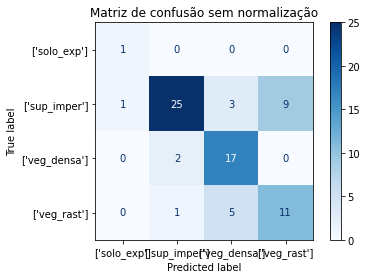

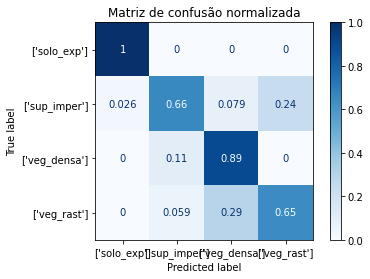

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
#classes
#class_names= None -> Se Nonefor fornecido, aqueles que aparecem pelo menos uma vez y_true ou y_pred são usados ​​em ordem de classificação.

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Matriz de confusão sem normalização", None),
                  ("Matriz de confusão normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, x_test, y_test,
                                 display_labels = None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

índice Kappa

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score( y_test , y_pred , labels = None )

0.5793269230769231

# Salvando o modelo

In [ ]:
import os
import joblib
import numpy as np

In [ ]:
# salvando o modelo na pasta do Google Drive
joblib.dump(clf, "/content/drive/MyDrive/a-PROJETO INICIA_CIENT/random_forest.joblib")

['/content/drive/MyDrive/a-PROJETO INICIA_CIENT/random_forest.joblib']

In [ ]:
# carregano o modelo na variável loaded_rf
loaded_rf = joblib.load("/content/drive/MyDrive/a-PROJETO INICIA_CIENT/random_forest.joblib")

In [ ]:
loaded_rf.predict(x_test)

array(["['sup_imper']", "['sup_imper']", "['sup_imper']", "['veg_rast']",
       "['sup_imper']", "['veg_densa']", "['veg_densa']", "['veg_densa']",
       "['veg_rast']", "['sup_imper']", "['sup_imper']", "['veg_densa']",
       "['veg_rast']", "['veg_rast']", "['sup_imper']", "['sup_imper']",
       "['veg_rast']", "['sup_imper']", "['veg_densa']", "['veg_rast']",
       "['veg_densa']", "['veg_rast']", "['sup_imper']", "['sup_imper']",
       "['sup_imper']", "['sup_imper']", "['sup_imper']", "['solo_exp']",
       "['sup_imper']", "['sup_imper']", "['sup_imper']", "['sup_imper']",
       "['veg_densa']", "['veg_densa']", "['sup_imper']", "['veg_densa']",
       "['sup_imper']", "['veg_densa']", "['veg_densa']", "['veg_densa']",
       "['sup_imper']", "['veg_rast']", "['veg_rast']", "['sup_imper']",
       "['veg_rast']", "['sup_imper']", "['veg_densa']", "['veg_rast']",
       "['sup_imper']", "['veg_densa']", "['veg_densa']", "['sup_imper']",
       "['veg_densa']", "['veg_rast']